In [29]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as st
np.random.seed(sum(map(ord,'aesthetics')))
sns.set_style('ticks')
sns.set_context('paper',font_scale=2,rc={'lines.linewidth':2.5})

pos_type_names = ['exp_id','rep','weather','start_point','end_point','result','initial_distance','final_distance',
                  'final_time','time_out','num_ped','num_veh','IpInjectProb','OpInjectProb','FrameDelay']

all_details_names=['exp_id','rep','weather','collision_gen','collision_ped','collision_car','lane_intersect',
                   'sidewalk_intersect','pos_x','pos_y','num_ped','num_veh','IpInjectProb','OpInjectProb','FrameDelay']

''' USE THIS WITH NEW LOGGING FORMAT from 0.8.1 (Phase 3 Onwards)
all_details_names=['exp_id','rep','weather','collision_gen','collision_ped','collision_car','lane_intersect',
                   'sidewalk_intersect','pos_x','pos_y','Injected','num_ped','num_veh','IpInjectProb','OpInjectProb','FrameDelay']
'''
class FI_Data(object):
    def __init__(self,town,f_i,fname_pose_type,fname_details):
        self.town=town
        self.f_i=f_i
        try:
            self.exp_by_pose_type = pd.read_csv(fname_pose_type,sep=',',names=pos_type_names,skiprows=1)
            self.exp_all_details = pd.read_csv(fname_details,sep=',',names=all_details_names,skiprows=1)
        except FileNotFoundError as e:
            print(e)
            self.exp_by_pose_type = pd.DataFrame(columns=pos_type_names)
            self.exp_all_details = pd.DataFrame(columns=all_details_names)
            pass
        
    def get_fi_name(self):
        return self.f_i
        
    def get_town_name(self):
        return self.town
    
    def get_exp_by_pose_type(self):
        return self.exp_by_pose_type
    
    def get_exp_all_details(self):
        return self.exp_all_details

In [68]:
#Input Injectors
PHSE = "Phase2"
DATASET = [
       FI_Data('Town1','NoInject',PHSE+'/uiuc_fi_2018_Town01_Pass_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town01_Pass_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town2','NoInject',PHSE+'/uiuc_fi_2018_Town02_Pass_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town02_Pass_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town1','Gaussian',PHSE+'/uiuc_fi_2018_Town01_Gaussian_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town01_Gaussian_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town2','Gaussian',PHSE+'/uiuc_fi_2018_Town02_Gaussian_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town02_Gaussian_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town1','S&P',PHSE+'/uiuc_fi_2018_Town01_SAndP_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town01_SAndP_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town2','S&P',PHSE+'/uiuc_fi_2018_Town02_SAndP_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town02_SAndP_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town1','Speckle',PHSE+'/uiuc_fi_2018_Town01_Speckle_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town01_Speckle_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town2','Speckle',PHSE+'/uiuc_fi_2018_Town02_Speckle_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town02_Speckle_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town1','SolidOcc',PHSE+'/uiuc_fi_2018_Town01_SolidOcc_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town01_SolidOcc_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town2','SolidOcc',PHSE+'/uiuc_fi_2018_Town02_SolidOcc_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town02_SolidOcc_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town1','TranspOcc',PHSE+'/uiuc_fi_2018_Town01_TransOcc_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town01_TransOcc_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town2','TranspOcc',PHSE+'/uiuc_fi_2018_Town02_TransOcc_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town02_TransOcc_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town1','WaterDrop',PHSE+'/uiuc_fi_2018_Town01_WaterDrop_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town01_WaterDrop_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town2','WaterDrop',PHSE+'/uiuc_fi_2018_Town02_WaterDrop_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town02_WaterDrop_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town1','Spd_Msr',PHSE+'/uiuc_fi_2018_Town01_SpeedM_0.8_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town01_SpeedM_0.8_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town2','Spd_Msr',PHSE+'/uiuc_fi_2018_Town02_SpeedM_0.8_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town02_SpeedM_0.8_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town1','Plan_Ctrl',PHSE+'/uiuc_fi_2018_Town01_Dirc_0.8_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town01_DirC_0.8_CtrlPass/details_w1.3.6.8.csv'),
       FI_Data('Town2','Plan_Ctrl',PHSE+'/uiuc_fi_2018_Town02_Dirc_0.8_CtrlPass/w1.3.6.8.csv',
              PHSE+'/uiuc_fi_2018_Town02_DirC_0.8_CtrlPass/details_w1.3.6.8.csv'),
       
       
   ]

for SET in DATASET:
    if SET.get_exp_by_pose_type().empty or SET.get_exp_all_details().empty:
        print("Deleting",SET.get_fi_name())
        DATASET.remove(SET)

File b'Phase2/uiuc_fi_2018_Town01_SpeedM_0.8_CtrlPass/w1.3.6.8.csv' does not exist
File b'Phase2/uiuc_fi_2018_Town01_Dirc_0.8_CtrlPass/w1.3.6.8.csv' does not exist
Deleting Spd_Msr
Deleting Plan_Ctrl


In [3]:
#Output Injectors for Delay Parameter Sweep
DATASET2 = [
    FI_Data('Town1','OutputDelay','raw_csv/delaysweep/Town01_Pass_CtrlDly/w1.3.6.8.csv',
           'raw_csv/delaysweep/Town01_Pass_CtrlDly/details_w1.3.6.8.csv'),
    FI_Data('Town2','OutputDelay','raw_csv/delaysweep/Town02_Pass_CtrlDly/w1.3.6.8.csv',
           'raw_csv/delaysweep/Town02_Pass_CtrlDly/details_w1.3.6.8.csv'),
    FI_Data('Town1','OutputDrop','raw_csv/delaysweep/Town01_Pass_CtrlDrp/w1.3.6.8.csv',
           'raw_csv/delaysweep/Town01_Pass_CtrlDrp/details_w1.3.6.8.csv'),
    FI_Data('Town2','OutputDrop','raw_csv/delaysweep/Town02_Pass_CtrlDrp/w1.3.6.8.csv',
           'raw_csv/delaysweep/Town02_Pass_CtrlDrp/details_w1.3.6.8.csv'),
]

In [4]:
#Function definitions to extract information from raw log files
#Credit to CARLA
sldist = lambda c1, c2: math.sqrt((c2[0] - c1[0])**2 + (c2[1] - c1[1])**2)

def get_distance_traveled(selected_matrix, header):

    prev_x = selected_matrix[0, header.index('pos_x')]
    prev_y = selected_matrix[0, header.index('pos_y')]

    i = 1
    acummulated_distance = 0
    while i < selected_matrix.shape[0]:

        x = selected_matrix[i, header.index('pos_x')]
        y = selected_matrix[i, header.index('pos_y')]
        # Here we defined a maximun distance in a tick, this case 8 meters or 288km/h
        if sldist((x, y), (prev_x, prev_y)) < 800:
            acummulated_distance += sldist((x, y), (prev_x, prev_y))


        prev_x = x
        prev_y = y

        i += 1

    return float(acummulated_distance)/float(100*1000)

def get_colisions(selected_matrix, header):

    count_gen = 0
    count_ped = 0
    count_car = 0
    i = 1

    while i < selected_matrix.shape[0]:
        if (selected_matrix[i, header.index('collision_gen')]
                - selected_matrix[(i-10), header.index('collision_gen')]) > 40000:
            count_gen += 1
            i += 20
        i += 1

    i = 1
    while i < selected_matrix.shape[0]:
        if (selected_matrix[i, header.index('collision_car')]
                - selected_matrix[(i-10), header.index('collision_car')]) > 40000:
            count_car += 1
            i += 30
        i += 1

    i = 1
    while i < selected_matrix.shape[0]:
        if (selected_matrix[i, header.index('collision_ped')]
                - selected_matrix[i-5, header.index('collision_ped')]) > 30000:
            count_ped += 1
            i += 100
        i += 1

    return count_gen, count_car, count_ped

def get_out_of_road_lane(selected_matrix, header):

    count_road = 0
    count_lane = 0

    i = 0

    while i < selected_matrix.shape[0]:
        # print selected_matrix[i,6]
        if (selected_matrix[i, header.index('sidewalk_intersect')]
                - selected_matrix[(i-10), header.index('sidewalk_intersect')]) > 0.3:
            count_road += 1
            i += 20
        if i >= selected_matrix.shape[0]:
            break

        if (selected_matrix[i, header.index('lane_intersect')]
                - selected_matrix[(i-10), header.index('lane_intersect')]) > 0.4:
            count_lane += 1
            i += 20

        i += 1

    return count_lane, count_road


In [69]:
infract_data = pd.DataFrame(columns=['FI', 'Town','Weather','Distance','col_gen', 'col_car', 'col_hum',
                                     'col_total','lane_out', 'swalk_out','infrac_total','km_infrac_total',
                                     'total_violations','violations_km'])

weather_id_name=['Default','ClearNoon','CloudyNoon','WetNoon','WetCloudyNoon','MidRainyNoon',
                 'HardRainNoon','SoftRainNoon','ClearSunset','CloudySunset','WetSunset',
                 'WetCloudySunset','MidRainSunset','HardRainSunset','SoftRainSunset']


for FI in DATASET:

    df = FI.get_exp_all_details()
    df2 = FI.get_exp_by_pose_type()
    
    unique_ids=np.unique(df["exp_id"].values)
    
    for exp_id in unique_ids:
        exp_mat = df.loc[df["exp_id"]==exp_id].values
        weather_id = np.unique((df.loc[df["exp_id"]==exp_id])["weather"].values)[0]
        
        km=get_distance_traveled(exp_mat,all_details_names)
        totalTime = sum((df2.loc[df2["exp_id"]==exp_id])["final_time"])/3600.0
        avg_speed = km/totalTime
        
        c_gen,c_car,c_ped = get_colisions(exp_mat,all_details_names)
        lane_out,swalk_out = get_out_of_road_lane(exp_mat,all_details_names)
        
        infract_data = infract_data.append({
            'FI':FI.get_fi_name(),
            'Town':FI.get_town_name(),
            'Weather':weather_id_name[weather_id],
            'Distance':km,
            'avg_speed':avg_speed,
            'col_gen':c_gen/km,
            'col_car':c_car/km,
            'col_hum':c_ped/km,
            'col_total':(c_gen+c_car+c_ped)/km,
            'lane_out':lane_out/km,
            'swalk_out':swalk_out/km,
            'infrac_total':(lane_out+swalk_out)/km,
            'km_infrac_total':km/(lane_out+swalk_out+1),
            'total_violations':(c_gen+c_car+c_ped+lane_out+swalk_out)/km,
            'violations_km':km/(c_gen+c_car+c_ped+lane_out+swalk_out+1)},ignore_index=True)

    

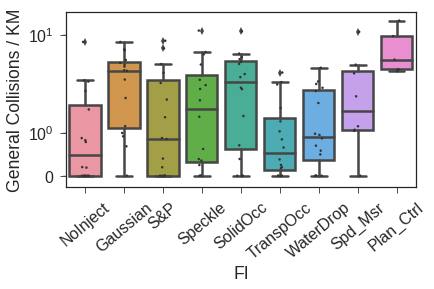

In [83]:
#(GeneralCollisions)/km by FI

ax = sns.boxplot(x='FI', y='col_gen', data=infract_data)
sns.stripplot(x='FI', y='col_gen', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('symlog')
ax.set_ylabel('General Collisions / KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/gen_coll_fi.pdf',bbox_inches='tight')
plt.show()

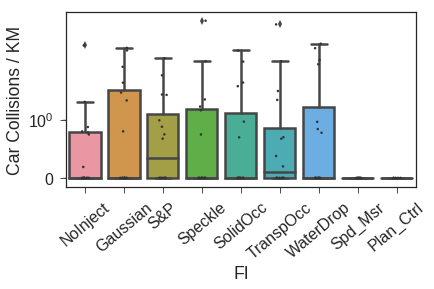

In [84]:
#(CarCollisions)/km by FI
ax = sns.boxplot(x='FI', y='col_car', data=infract_data)
sns.stripplot(x='FI', y='col_car', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('symlog')
ax.set_ylabel('Car Collisions / KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/car_coll_fi.pdf',bbox_inches='tight')
plt.show()


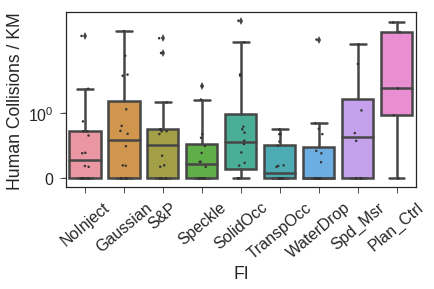

In [85]:
#(HumanCollisions)/km by FI
ax = sns.boxplot(x='FI', y='col_hum', data=infract_data)
sns.stripplot(x='FI', y='col_hum', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('symlog')
ax.set_ylabel('Human Collisions / KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/hum_coll_fi.pdf',bbox_inches='tight')
plt.show()

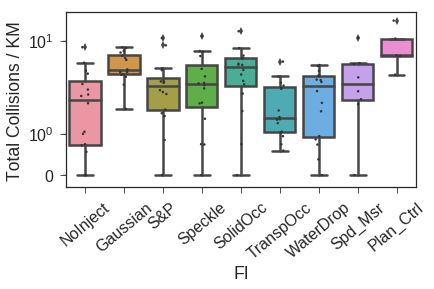

In [86]:
#(TotalCollisions)/km by FI
ax = sns.boxplot(x='FI', y='col_total', data=infract_data)
sns.stripplot(x='FI', y='col_total', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('symlog')
ax.set_ylabel('Total Collisions / KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/coll_fi.pdf',bbox_inches='tight')
plt.show()

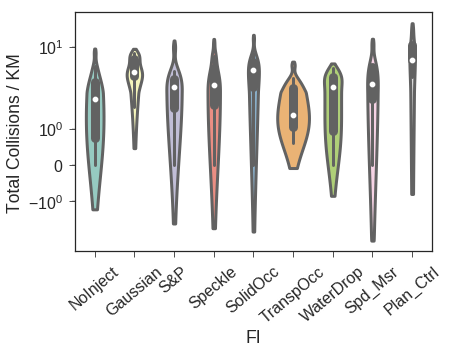

In [106]:
ax=sns.violinplot(x='FI', y='col_total', data=infract_data, palette="Set3", cut=1, linewidth=3)
ax.set_yscale('symlog')
ax.set_ylabel('Total Collisions / KM')
plt.xticks(rotation=40)
plt.savefig('figs/coll_fi_viol.pdf',bbox_inches='tight')
plt.show()

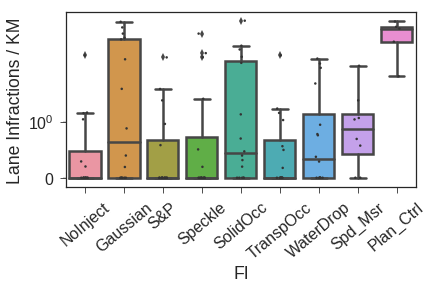

In [87]:
#(LaneInfractions)/km by FI
ax = sns.boxplot(x='FI', y='lane_out', data=infract_data)
sns.stripplot(x='FI', y='lane_out', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('symlog')
ax.set_ylabel('Lane Infractions / KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/lane_infract_fi.pdf',bbox_inches='tight')
plt.show()

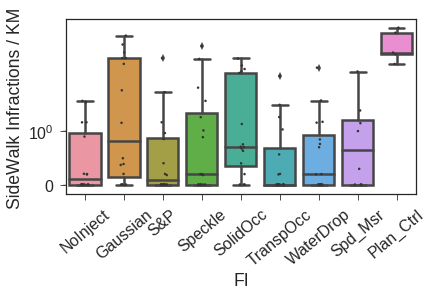

In [88]:
#(SideWalkInfractions)/km by FI
ax = sns.boxplot(x='FI', y='swalk_out', data=infract_data)
sns.stripplot(x='FI', y='swalk_out', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('symlog')
ax.set_ylabel('SideWalk Infractions / KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/swalk_infract_fi.pdf',bbox_inches='tight')
plt.show()

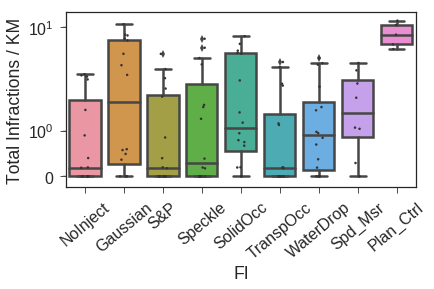

In [89]:
#(TotalInfractions)/km by FI
ax = sns.boxplot(x='FI', y='infrac_total', data=infract_data)
sns.stripplot(x='FI', y='infrac_total', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('symlog')
ax.set_ylabel('Total Infractions / KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/infract_fi.pdf',bbox_inches='tight')
plt.show()

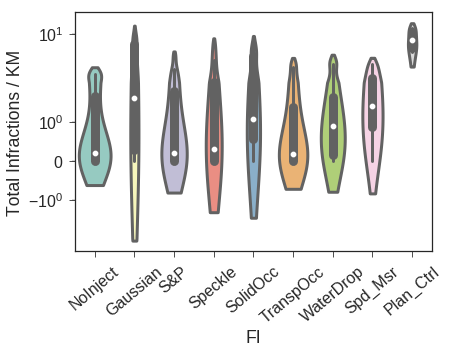

In [107]:
ax=sns.violinplot(x='FI', y='infrac_total', data=infract_data, palette="Set3", cut=1, linewidth=3)
ax.set_yscale('symlog')
ax.set_ylabel('Total Infractions / KM')
plt.xticks(rotation=40)
plt.savefig('figs/infract_fi_viol.pdf',bbox_inches='tight')
plt.show()

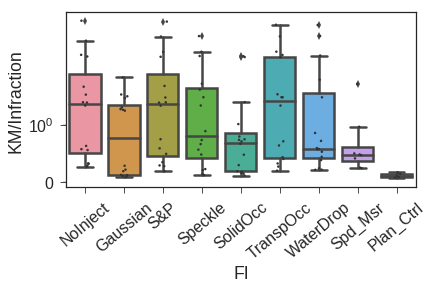

In [90]:
#(KM/Infraction)
ax = sns.boxplot(x='FI', y='km_infrac_total', data=infract_data)
sns.stripplot(x='FI', y='km_infrac_total', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('symlog')
ax.set_ylabel('KM/Infraction')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/inv_infract_fi.pdf',bbox_inches='tight')
plt.show()

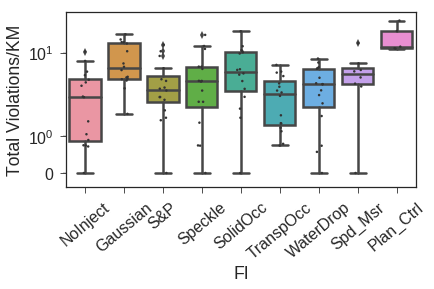

In [91]:
#(TotalViolations/KM)
ax = sns.boxplot(x='FI', y='total_violations', data=infract_data)
sns.stripplot(x='FI', y='total_violations', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('symlog')
ax.set_ylabel('Total Violations/KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/tv_fi.pdf',bbox_inches='tight')
plt.show()

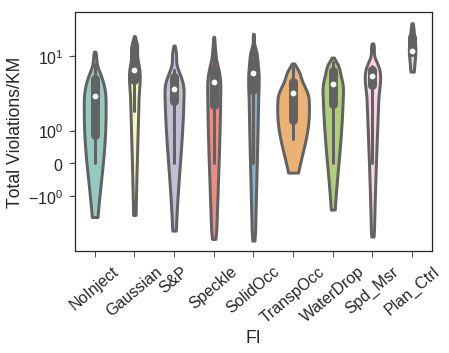

In [103]:
ax=sns.violinplot(x="FI",y="total_violations",data=infract_data, palette="Set3", cut=1, linewidth=3)
ax.set_yscale('symlog')
ax.set_ylabel("Total Violations/KM")
plt.xticks(rotation=40)
plt.savefig('figs/tv_fi_viol.pdf',bbox_inches='tight')
plt.show()

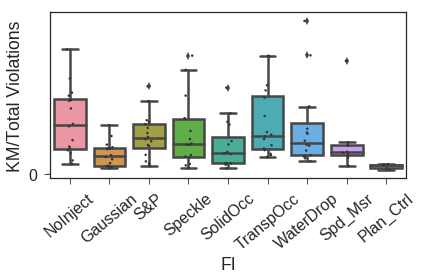

In [28]:
#(KM/TotalViolations)
ax = sns.boxplot(x='FI', y='violations_km', data=infract_data)
sns.stripplot(x='FI', y='violations_km', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('symlog')
ax.set_ylabel('KM/Total Violations')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/inv_tv_FI.pdf',bbox_inches='tight')
plt.show()

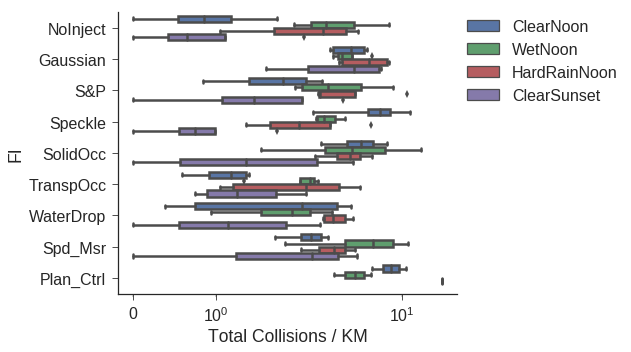

In [16]:
# FI vs Collisions/KM
ax = sns.factorplot(x="col_total", y="FI", hue="Weather", data=infract_data,
                    kind="box", orient="h", size=5, aspect=16/9, legend=False)
ax.set_axis_labels('Total Collisions / KM', 'FI')
ax.ax.set_xscale('symlog')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# format_figure(ax)
plt.tight_layout()
plt.savefig('figs/FI_w_coll.pdf',bbox_inches='tight')
plt.show()
    

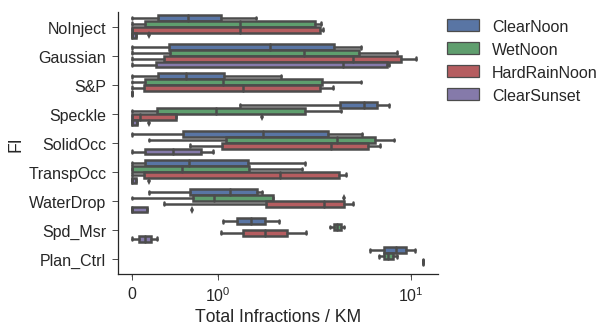

In [30]:
# FI vs Infractions/KM
ax = sns.factorplot(x="infrac_total", y="FI", hue="Weather", data=infract_data,
                    kind="box", orient="h", size=5, aspect=16/9, legend=False)
ax.set_axis_labels('Total Infractions / KM', 'FI')
ax.ax.set_xscale('symlog')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# format_figure(ax)
plt.tight_layout()
plt.savefig('figs/FI_w_infract.pdf',bbox_inches='tight')
plt.show()
    

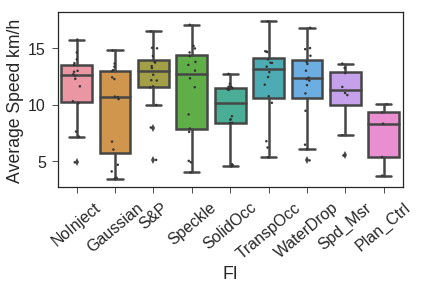

In [31]:
#(Average Speed)
ax = sns.boxplot(x='FI', y='avg_speed', data=infract_data)
sns.stripplot(x='FI', y='avg_speed', data=infract_data, color='0.2', jitter=True, marker=".")
ax.set_ylabel('Average Speed km/h')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/speed_FI.pdf',bbox_inches='tight')
plt.show()

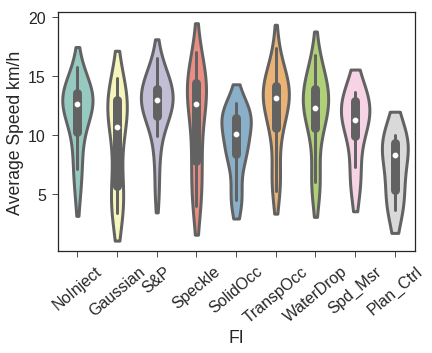

In [102]:
ax=sns.violinplot(x="FI",y="avg_speed",data=infract_data, palette="Set3", cut=1, linewidth=3)
ax.set_ylabel("Average Speed km/h")
plt.xticks(rotation=40)
plt.savefig('figs/speed_FI_viol.pdf',bbox_inches='tight')
plt.show()

In [92]:
completion_data = pd.DataFrame(columns=['FI', 'Town','Weather','CompletionTime'])

weather_id_name=['Default','ClearNoon','CloudyNoon','WetNoon','WetCloudyNoon','MidRainyNoon',
                 'HardRainNoon','SoftRainNoon','ClearSunset','CloudySunset','WetSunset',
                 'WetCloudySunset','MidRainSunset','HardRainSunset','SoftRainSunset']


for FI in DATASET:

    df = FI.get_exp_by_pose_type()
    
    completion_times=df[["exp_id","final_time"]].values
    
    for entry in completion_times:
        completion_data = completion_data.append({
            'FI':FI.get_fi_name(),
            'Town':FI.get_town_name(),
            'Weather':weather_id_name[weather_id],
            'CompletionTime':entry[1]},ignore_index=True)


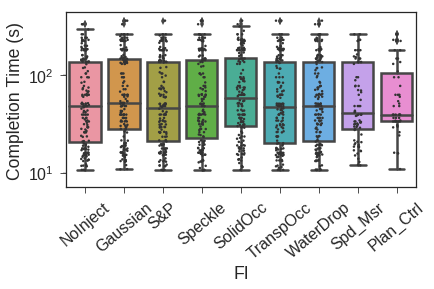

In [93]:
#Completion Times by FI
ax = sns.boxplot(x='FI', y='CompletionTime', data=completion_data)
sns.stripplot(x='FI', y='CompletionTime', data=completion_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('symlog')
ax.set_ylabel('Completion Time (s)')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/cy_FI.pdf',bbox_inches='tight')
plt.show()

In [97]:
success_data = pd.DataFrame(columns=['FI', 'Town','Weather','SuccessRate'])
for FI in DATASET:
    df = FI.get_exp_by_pose_type()
    unique_ids=np.unique(df["exp_id"].values)
    
    for exp_id in unique_ids:
        exp_df = df.loc[df["exp_id"]==exp_id]
        
        reached=0
        total=0
        for index,row in exp_df.iterrows():
            if(row['final_time']<row['time_out']):
                reached+=1
            total+=1
        success_rate=reached/total*100
        success_data = success_data.append({
            'FI':FI.get_fi_name(),
            'Town':FI.get_town_name(),
            'Weather':weather_id_name[weather_id],
            'SuccessRate':success_rate},ignore_index=True)


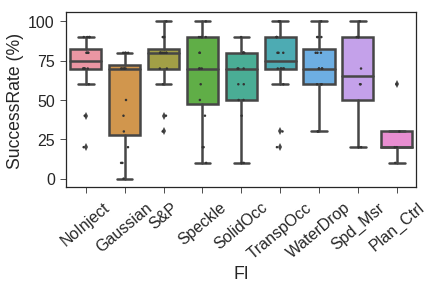

In [98]:
#SuccessRates
ax = sns.boxplot(x='FI', y='SuccessRate', data=success_data)
sns.stripplot(x='FI', y='SuccessRate', data=success_data, color='0.2', jitter=True, marker=".")
ax.set_ylabel('SuccessRate (%)')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/succRate_FI.pdf',bbox_inches='tight')
plt.show()

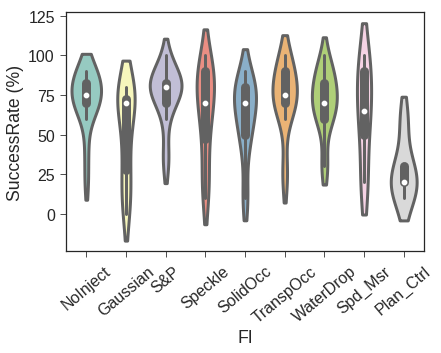

In [99]:
ax=sns.violinplot(x="FI",y="SuccessRate",data=success_data, palette="Set3", cut=1, linewidth=3)
ax.set_ylabel('SuccessRate (%)')
plt.xticks(rotation=40)
plt.savefig('figs/succRate_FI_viol.pdf',bbox_inches='tight')
plt.show()

In [100]:
infract_data_out = pd.DataFrame(columns=['FI', 'Town','Weather','Distance',
                                        'total_violations','violations_km'])

weather_id_name=['Default','ClearNoon','CloudyNoon','WetNoon','WetCloudyNoon','MidRainyNoon',
                 'HardRainNoon','SoftRainNoon','ClearSunset','CloudySunset','WetSunset',
                 'WetCloudySunset','MidRainSunset','HardRainSunset','SoftRainSunset']

DELAYDATA = [SET for SET in DATASET2 if SET.get_fi_name()=='OutputDelay']
for FI in DELAYDATA:

    df = FI.get_exp_all_details()

    unique_frame_delays = np.unique(df["FrameDelay"].values)
    
    for delay in unique_frame_delays:
        sub_df=df.loc[df["FrameDelay"]==delay]
        unique_ids=np.unique(df["exp_id"].values)
        for exp_id in unique_ids:
            exp_mat = sub_df.loc[df["exp_id"]==exp_id].values
            weather_id = np.unique((df.loc[df["exp_id"]==exp_id])["weather"].values)[0]
            
            km=get_distance_traveled(exp_mat,all_details_names)
            
            c_gen,c_car,c_ped = get_colisions(exp_mat,all_details_names)
            lane_out,swalk_out = get_out_of_road_lane(exp_mat,all_details_names)
            
            infract_data_out = infract_data_out.append({
                'FI':FI.get_fi_name(),
                'Town':FI.get_town_name(),
                'Weather':weather_id_name[weather_id],
                'FrameDelay': delay,
                'Distance':km,
                'total_violations':(c_gen+c_car+c_ped+lane_out+swalk_out)/km,
                'violations_km':km/(c_gen+c_car+c_ped+lane_out+swalk_out+1)},ignore_index=True)

    

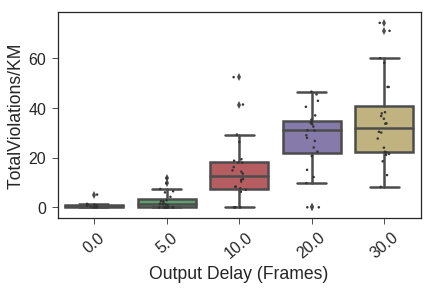

In [101]:
#TotalViolations/km vs OutputFrameDelay
ax = sns.boxplot(x='FrameDelay', y='total_violations', data=infract_data_out)
sns.stripplot(x='FrameDelay', y='total_violations', data=infract_data_out, color='0.2', jitter=True, marker=".")
#ax.set_yscale('symlog')
ax.set_xlabel('Output Delay (Frames)')
ax.set_ylabel('TotalViolations/KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/tv_ofd.pdf',bbox_inches='tight')
plt.show()

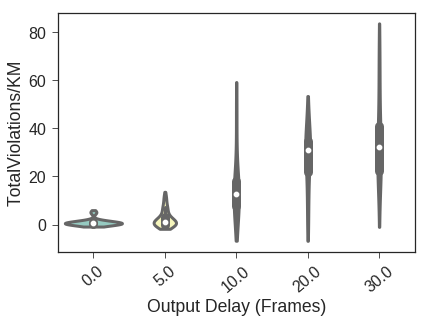

In [104]:
ax=sns.violinplot(x='FrameDelay', y='total_violations',data=infract_data_out, palette="Set3", cut=1, linewidth=3)
ax.set_xlabel('Output Delay (Frames)')
ax.set_ylabel('TotalViolations/KM')
plt.xticks(rotation=40)
plt.savefig('figs/tv_ofd_viol.pdf',bbox_inches='tight')
plt.show()

In [38]:
infract_data_out = pd.DataFrame(columns=['FI', 'Town','Weather','Distance',
                                        'total_violations','violations_km'])

weather_id_name=['Default','ClearNoon','CloudyNoon','WetNoon','WetCloudyNoon','MidRainyNoon',
                 'HardRainNoon','SoftRainNoon','ClearSunset','CloudySunset','WetSunset',
                 'WetCloudySunset','MidRainSunset','HardRainSunset','SoftRainSunset']

DROPDATA = [SET for SET in DATASET2 if SET.get_fi_name()=='OutputDrop']
for FI in DROPDATA:

    df = FI.get_exp_all_details()

    unique_frame_delays = np.unique(df["FrameDelay"].values)
    
    for delay in unique_frame_delays:
        sub_df=df.loc[df["FrameDelay"]==delay]
        unique_ids=np.unique(df["exp_id"].values)
        for exp_id in unique_ids:
            exp_mat = sub_df.loc[df["exp_id"]==exp_id].values
            weather_id = np.unique((df.loc[df["exp_id"]==exp_id])["weather"].values)[0]
            
            km=get_distance_traveled(exp_mat,all_details_names)
            
            c_gen,c_car,c_ped = get_colisions(exp_mat,all_details_names)
            lane_out,swalk_out = get_out_of_road_lane(exp_mat,all_details_names)
            
            infract_data_out = infract_data_out.append({
                'FI':FI.get_fi_name(),
                'Town':FI.get_town_name(),
                'Weather':weather_id_name[weather_id],
                'FrameDelay': delay,
                'Distance':km,
                'total_violations':(c_gen+c_car+c_ped+lane_out+swalk_out)/km,
                'violations_km':km/(c_gen+c_car+c_ped+lane_out+swalk_out+1)},ignore_index=True)


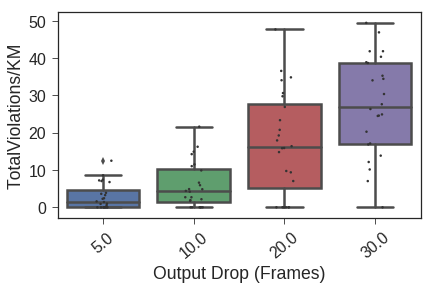

In [39]:
#TotalViolations/km vs OutputFrameDelay
ax = sns.boxplot(x='FrameDelay', y='total_violations', data=infract_data_out)
sns.stripplot(x='FrameDelay', y='total_violations', data=infract_data_out, color='0.2', jitter=True, marker=".")
#ax.set_yscale('symlog')
ax.set_xlabel('Output Drop (Frames)')
ax.set_ylabel('TotalViolations/KM')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('figs/tv_odd.pdf',bbox_inches='tight')
plt.show()